In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import json

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('sample_data/6-features-34k-rows.csv')
data_df = pd.DataFrame(data)

In [ ]:
data_df.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate,class
0,45,3,38823,43269,0.000002,0.000075,TELNET
1,46,4,21859,40481,0.000050,0.002300,FTP
2,226,207,17430,28950,0.000002,0.000461,HTTP
3,225,248,40103,61819,0.000026,0.005958,localForwarding
4,8222,7849,9423,23976,0.000106,0.873337,remoteForwarding


In [ ]:
# Changing class names to numerical values
class_name =data_df['class'].unique()
le = preprocessing.LabelEncoder()
le.fit(data_df['class'])
data_df['class']=le.transform(data_df['class'])
class_id = data_df['class'].unique()

In [ ]:
data_df.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate,class
0,45,3,38823,43269,0.000002,0.000075,3
1,46,4,21859,40481,0.000050,0.002300,1
2,226,207,17430,28950,0.000002,0.000461,2
3,225,248,40103,61819,0.000026,0.005958,5
4,8222,7849,9423,23976,0.000106,0.873337,6


In [ ]:
# Mapping class names and ids(numerical values)
class_dict={}
for i in range(0,len(class_name)):
    class_dict[int(class_id[i])]=class_name[i]

print(class_dict)

{3: 'TELNET', 1: 'FTP', 2: 'HTTP', 5: 'localForwarding', 6: 'remoteForwarding', 7: 'scp', 8: 'sftp', 10: 'x11', 9: 'shell', 0: 'DNS', 4: 'lime'}


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34803 entries, 0 to 34802
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_fpktl  34803 non-null  int64  
 1   std_fpktl   34803 non-null  int64  
 2   mean_fiat   34803 non-null  int64  
 3   std_fiat    34803 non-null  int64  
 4   fpkt_rate   34803 non-null  float64
 5   fbyte_rate  34803 non-null  float64
 6   class       34803 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.9 MB


In [ ]:
# Dividing into training and testing sets 80:20
#X = data_df.drop(['class'],axis=1)
X = data_df[['mean_fpktl','std_fpktl','mean_fiat','std_fiat','fpkt_rate','fbyte_rate']]
y = np.ravel(data_df['class'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	for i in range(len(dataset[0])):
		col_values = [row[i] for row in dataset]
		value_min = min(col_values)
		value_max = max(col_values)
		minmax.append([value_min, value_max])
	return minmax

def normalize_data(dataset,minmax,convNDArray=False):
	# minmax = dataset_minmax(dataFrame.values)
	for row in dataset:
		for i in range(len(row)):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
	if convNDArray:
		return dataset
	colList = list(dataFrame.columns.values)
	sample_dict = {}
	for i in range(len(colList)):
		sample_dict[colList[i]] = data[:, i]
	dataFrame = pd.DataFrame(sample_dict)
	return dataFrame

In [ ]:
# calculate column means
def column_means(dataset):
	means = [0 for i in range(len(dataset[0]))]
	for i in range(len(dataset[0])):
		col_values = [row[i] for row in dataset]
		means[i] = sum(col_values) / float(len(dataset))
	return means
 
# calculate column standard deviations
def column_stdevs(dataset, means):
	#dataset = dataFrame.values
	stdevs = [0 for i in range(len(dataset[0]))]
	for i in range(len(dataset[0])):
		variance = [pow(row[i]-means[i], 2) for row in dataset]
		stdevs[i] = sum(variance)
	stdevs = [sqrt(x/(float(len(dataset)-1))) for x in stdevs]
	return stdevs
 
# standardize dataset
def standardize_data(dataset, means, stdevs,convNDArray=False):
	#dataset = dataFrame.values
	for row in dataset:
		for i in range(len(row)):
			row[i] = (row[i] - means[i]) / stdevs[i]
	if convNDArray:
		return dataset
	colList = list(dataFrame.columns.values)
	sample_dict = {}
	for i in range(len(colList)):
		sample_dict[colList[i]] = dataset[:, i]
	dataFrame = pd.DataFrame(sample_dict)
	return dataFrame

In [ ]:
def standardize_data1(dataFrame, means, stdevs,convNDArray=False):
	dataset = dataFrame.values
	for row in dataset:
		for i in range(len(row)):
			row[i] = (row[i] - means[i]) / stdevs[i]
	if convNDArray:
		return dataset
	colList = list(dataFrame.columns.values)
	sample_dict = {}
	for i in range(len(colList)):
		sample_dict[colList[i]] = dataset[:, i]
	dataFrame = pd.DataFrame(sample_dict)
	return dataFrame

In [ ]:
minmax = dataset_minmax(X_train.values)
means = column_means(X_train.values)
stddevs = column_stdevs(X_train.values,means)
A = standardize_data1(X_train,means,stddevs)
data_df.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate,class
0,45,3,38823,43269,0.000002,0.000075,3
1,46,4,21859,40481,0.000050,0.002300,1
2,226,207,17430,28950,0.000002,0.000461,2
3,225,248,40103,61819,0.000026,0.005958,5
4,8222,7849,9423,23976,0.000106,0.873337,6


In [ ]:
A.head()

,mean_fpktl,std_fpktl,mean_fiat,std_fiat,fpkt_rate,fbyte_rate
0,-0.531617,-0.330794,0.409007,0.897591,-0.465548,-0.522159
1,-0.524640,-0.338927,0.732300,0.576005,-0.516072,-0.523885
2,0.188491,-0.311987,-0.774086,-1.055495,0.648730,0.628389
3,3.557798,3.767713,-0.504520,0.000822,-0.290028,0.713491
4,-0.469324,-0.234724,-0.378453,-0.437441,-0.343948,-0.503678


In [ ]:
print((X_train.values).shape)

(27842, 6)


In [ ]:
print(len(minmax))
print(len(means))
print(len(stddevs))

6
6
6


In [ ]:
X_train = standardize_data(X_train.values,means,stddevs,True)
X_test = standardize_data(X_test.values,means,stddevs,True)
print(X_test.shape)

(6961, 6)


In [ ]:
# Defining the model
layers = 50
layers -= 7
model = Sequential()
model.add(Dense((256), activation='relu', input_shape=(6,)))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
for i in range(0,layers):
    model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(11,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1792      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [ ]:
# Training the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
history = model.fit(X_train, y_train,epochs=100, batch_size=256, verbose=1,validation_data=(X_test,y_test))

Epoch 1/100
109/109 [==============================] - 1s 11ms/step - loss: 2.0468 - accuracy: 0.3938 - val_loss: 1.8124 - val_accuracy: 0.4271
Epoch 2/100
109/109 [==============================] - 1s 7ms/step - loss: 1.4653 - accuracy: 0.4864 - val_loss: 1.1951 - val_accuracy: 0.5162
Epoch 3/100
109/109 [==============================] - 1s 7ms/step - loss: 1.0620 - accuracy: 0.6031 - val_loss: 0.8974 - val_accuracy: 0.6717
Epoch 4/100
109/109 [==============================] - 1s 7ms/step - loss: 0.9111 - accuracy: 0.6541 - val_loss: 0.7992 - val_accuracy: 0.6683
Epoch 5/100
109/109 [==============================] - 1s 7ms/step - loss: 0.8370 - accuracy: 0.6730 - val_loss: 0.7753 - val_accuracy: 0.6815
Epoch 6/100
109/109 [==============================] - 1s 7ms/step - loss: 0.7987 - accuracy: 0.6885 - val_loss: 0.7457 - val_accuracy: 0.6953
Epoch 7/100
109/109 [==============================] - 1s 7ms/step - loss: 0.7901 - accuracy: 0.6897 - val_loss: 0.7459 - val_accuracy: 0.698

In [ ]:
his_dict = history.history
for key in his_dict:
    print(key)

loss
accuracy
val_loss
val_accuracy


<Figure size 432x288 with 0 Axes>

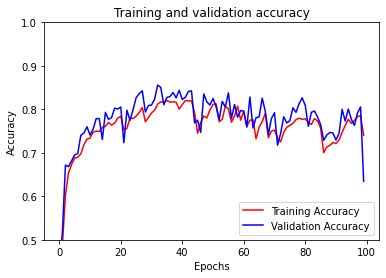

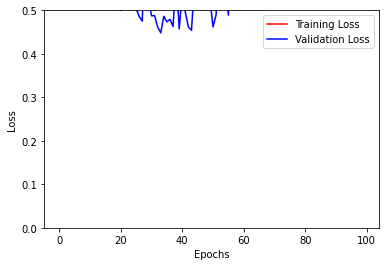

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting accuracy and loss

%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy",)
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim(0.5, 1.0)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,0.5)
plt.legend(loc='upper right')
plt.figure()

In [ ]:
import pandas as pd

def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = ' '.join(line.split()) 
        row_data = row_data.split(' ')
        #print(len(row_data))
        if len(row_data)==5:
            #row['class'] = row_data[0]
            row['f1_score'] = float(row_data[3])
            report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report.csv', mode = 'a',header = False,index = False)

In [ ]:
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred_bool)
print(report)
classification_report_csv(report)
print(confusion_matrix(y_test, y_pred_bool))
print("\nMap to class id and class name: ")
print(json.dumps(class_dict, indent=4, sort_keys=True))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       285
           1       0.00      0.00      0.00        64
           2       0.74      0.16      0.26       733
           3       0.00      0.00      0.00       205
           4       0.79      0.97      0.87      2973
           5       0.40      1.00      0.57       517
           6       1.00      0.98      0.99       494
           7       0.36      0.12      0.18       479
           8       0.00      0.00      0.00       457
           9       0.29      0.97      0.45       378
          10       0.00      0.00      0.00       376

    accuracy                           0.63      6961
   macro avg       0.33      0.38      0.30      6961
weighted avg       0.56      0.63      0.55      6961

[[   0    0    0    0  285    0    0    0    0    0    0]
 [   0    0    0    0   63    0    0    0    0    1    0]
 [   0    0  114    0  179    0    0    0    0  440    0]
 [   0    0  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
# def predict(sample):
#     # Parameters layer 1
#     W1 = model.get_weights()[0]
#     b1 = model.get_weights()[1]

#     # Parameters layer 2
#     W2 = model.get_weights()[2]
#     b2 = model.get_weights()[3]

#     # Parameters layer 3
#     W3 = model.get_weights()[4]
#     b3 = model.get_weights()[5]

#     # Parameters layer 4
#     W4 = model.get_weights()[6]
#     b4 = model.get_weights()[7]

    
#     L1 = np.dot(sample,W1)+b1
#     L1 = np.maximum(L1,0)
#     L2 = np.dot(L1,W2)+b2
#     L2 = np.maximum(L2,0)
#     L3 = np.dot(L2,W3)+b3
#     L3 = np.maximum(L3,0)
#     L4 = np.dot(L3,W4)+b4
#     output = softmax(L4)
#     return output

In [ ]:
weights = model.get_weights()
type(weights)
len(weights)
print(weights[0].shape)

(6, 256)


In [ ]:
import pickle
with open("data/means.txt", "wb") as f:
    pickle.dump(means,f)
with open("data/stddevs.txt", "wb") as f:
    pickle.dump(stddevs,f)
with open("data/weights.txt", "wb") as f:
    pickle.dump(weights,f)

FileNotFoundError: ignored

In [ ]:
def predictG(sample,weights):
    layers = int(len(weights)/2)
    L = np.dot(sample,weights[0]) + weights[1]
    L = np.maximum(L,0)
    for i in range(1,layers):
        L = np.dot(L,weights[2*i]) + weights[2*i+1]
        if i != layers-1:
            L = np.maximum(L,0)
        else:
            L = softmax(L)
    return L

In [ ]:
X_train[0].shape

In [ ]:
print(np.around(predictG(X_train[5],weights),decimals=3))

In [ ]:
print(np.around(model.predict(X_train)[5],decimals=3))

In [ ]:
print(np.around(model.predict(X_test)[15],decimals=3))

In [ ]:
print(np.around(predictG(X_test[15],weights),decimals=3))

In [ ]:
m,s,w = None,None,None
with open("data/means.txt", "rb") as f:
    m = pickle.load(f)
with open("data/stddevs.txt", "rb") as f:
    s = pickle.load(f)
with open("data/weights.txt", "rb") as f:
    w = pickle.load(f)

In [ ]:
print(m)

In [ ]:
print(w)

In [ ]:
print(np.around(predictG(X_train[5],w),decimals=3))

In [ ]:
for row in weights:
    print(row.shape)